In [1]:
#pip install pandas numpy scikit-learn matplotlib yfinance tensorflow[and-cuda] scikeras keras_tuner

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras_tuner as kt
from keras_tuner import HyperModel, Hyperband

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow import keras

from graphing import graph_normal, show_results
from get_data import get_apple_stock_split

In [6]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

DAYS_LAG = 5

X_train, X_test, y_train, y_test = get_apple_stock_split(DAYS_LAG)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


X_train = scaler_X.fit_transform(X_train)
y_train = scaler_Y.fit_transform(y_train)

X_test = scaler_X.transform(X_test)
y_test = scaler_Y.transform(y_test)

[*********************100%***********************]  1 of 1 completed

Training samples: 1164, Testing samples: 291


In [12]:
#repeatable way to create the model 
def create_ann(hp):
    model = keras.Sequential([
        keras.Input(shape=(X_train.shape[1],)),  # Define input shape using Input layer
        keras.layers.Dense(
                            hp.Int('units1', min_value=32, max_value=256, step=32),
                            activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])),
        keras.layers.Dense(
                            hp.Int('units2', min_value=32, max_value=256, step=32),
                            activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])),
        keras.layers.Dense(1, activation='linear')  # Linear activation for regression
                           
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.0001])),
        loss='mse', metrics=['mae'])
    return model

In [16]:
tuner = kt.RandomSearch(
    create_ann,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='time_series_ann'
)
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


Trial 10 Complete [00h 00m 12s]
val_mae: 0.6415464282035828

Best val_mae So Far: 0.6415464282035828
Total elapsed time: 00h 01m 59s


In [17]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'units1': 128, 'activation': 'sigmoid', 'units2': 64, 'learning_rate': 0.01}


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Final Model MAE: 0.6415464248165745
Final Model RMSE: 0.9353757502260622


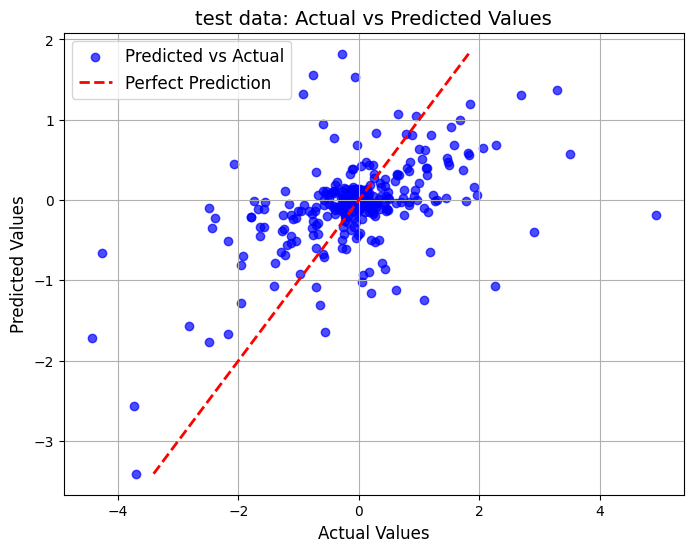

test data  MAE: 0.6415464248165745
test data  RMSE: 0.9353757502260622


In [18]:
# Get the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

predictions = best_model.predict(X_test).flatten()

results = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': predictions
})

# Evaluate the final model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")

graph_normal(predictions, y_test, "test data")

In [19]:
from results import get_num_correct_direction

get_num_correct_direction(predictions, y_test.flatten())

179 correct directions out of a total: 291


In [22]:
predictions_original = scaler_Y.inverse_transform(predictions.reshape(-1, 1)).flatten()

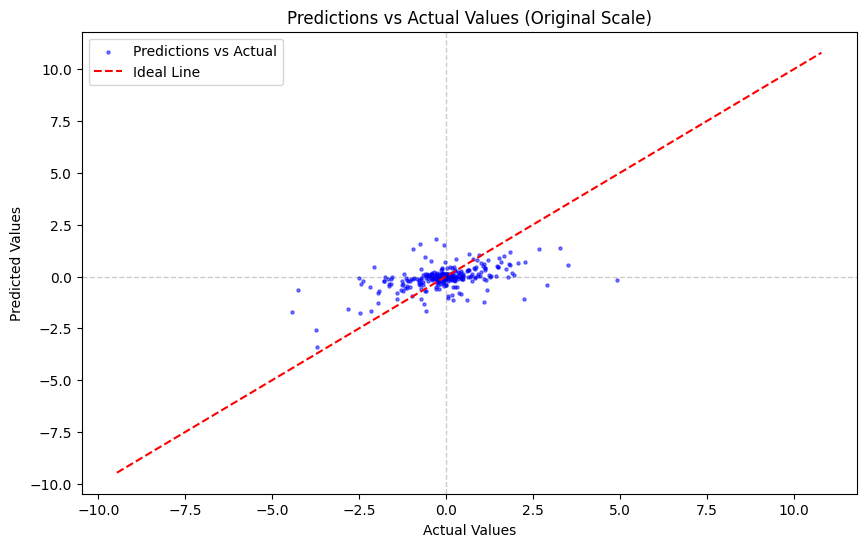

In [23]:
predictions_original = scaler_Y.inverse_transform(predictions.reshape(-1, 1)).flatten()

y_test_original = scaler_Y.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.5, label='Predictions vs Actual', s =5)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--', label='Ideal Line')

# Adding lines at y = 0 and x = 0
plt.axhline(0, color='black', linestyle='--',alpha=0.2, linewidth=1)  # Horizontal line at y = 0
plt.axvline(0, color='black', linestyle='--',alpha=0.2, linewidth=1)  # Vertical line at x = 0

# Labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values (Original Scale)')
plt.legend()

# Show the plot
plt.show()